In [ ]:
from src.sampling.images import plot_frame_count_distributions

samples_root_dir = "data/samples"

plot_frame_count_distributions(samples_root_dir)

In [ ]:
from sota.model import SOTA

sota = SOTA("data", "yolo11m-cls")
sota.initialize_model()
sota.train_model(optimizer="AdamW", lr0=0.0005)


#metrics = model.val(data="data/img/techniques/val")

In [ ]:
from sota.model import SOTA

sota = SOTA("data", "yolo11n-cls")
sota.initialize_model()
sota.train_model()

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-balance-50-155", dataset_name="techniques_balanced")
sota.initialize_model("yolo11m-cls")
sota.train_model()

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11n-balance-50-155", dataset_name="techniques_balanced")
sota.initialize_model("yolo11n-cls")
#sota.train_model()
sota.test_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1")
hpednn.initialize_model()
hpednn.train_model()

In [ ]:
%load_ext tensorboard

from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1_balanced", "techniques_balanced")
hpednn.initialize_model()
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch2_balanced", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH2)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch3_balanced", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH3)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch1_balanced_not_norm", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH1, normalize=False)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch1_balanced_dr_0.3", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH1, dropout_rate=0.3)
hpednn.train_model()

In [ ]:
%tensorboard --logdir data/runs/hpe_dnn/arch1_balanced/train1/logs/train

In [ ]:
from typing import NamedTuple
from src.hpe.evaluate import _used_hand_landmarks, _used_pose_landmarks
from numpy import array
from pandas import Series

def __series_to_augmenting_array(input: Series, height, width):
    xyz = []
    vis = []
    labels = []
    mask = []
    


def __to_augmenting_array(results: NamedTuple, heigth, width):
    xyz = []
    vis = []
    labels = []
    mask = []

    for landmark in _used_pose_landmarks:
        if (results.pose_landmarks is not None):
            xyz.append((
                results.pose_landmarks.landmark[landmark].x * width, 
                results.pose_landmarks.landmark[landmark].y * heigth,
                # z scaled according to x: https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker/python
                results.pose_landmarks.landmark[landmark].z * width 
            ))
            vis.append(results.pose_landmarks.landmark[landmark].visibility)
            mask.append(True)
        else:
            vis.append(None)
            mask.append(False)
        
        labels.append(landmark)

    for landmark in _used_hand_landmarks:
        if (results.right_hand_landmarks is not None):
            xyz.append((
                results.right_hand_landmarks.landmark[landmark].x * width, 
                results.right_hand_landmarks.landmark[landmark].y * heigth,
                results.right_hand_landmarks.landmark[landmark].z * width
            ))
            mask.append(True)
        else:
            mask.append(False)

        vis.append(None)
        labels.append(landmark)

    for landmark in _used_hand_landmarks:
        if (results.left_hand_landmarks is not None):
            xyz.append((
                results.left_hand_landmarks.landmark[landmark].x * width, 
                results.left_hand_landmarks.landmark[landmark].y * heigth,
                results.left_hand_landmarks.landmark[landmark].z * width
            ))
            mask.append(True)
        else:
            mask.append(False)

        vis.append(None)
        labels.append(landmark)

    return (xyz, vis, labels, mask)


def __to_augmenting_array2(results: NamedTuple, heigth, width):
    xyz = []
    vis = []
    labels = [] 

    for landmark in _used_pose_landmarks:
        if (results.pose_landmarks is None):
            xyz.append((None, None, None))
            vis.append(None)
            labels.append(landmark)
        else:
            xyz.append((
                results.pose_landmarks.landmark[landmark].x * width, 
                results.pose_landmarks.landmark[landmark].y * heigth,
                # z scaled according to x: https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker/python
                results.pose_landmarks.landmark[landmark].z * width 
            ))
            vis.append(results.pose_landmarks.landmark[landmark].visibility)
            labels.append(landmark)

    for landmark in _used_hand_landmarks:
        if (results.right_hand_landmarks is None):
            xyz.append((None, None, None))
            vis.append(None)
            labels.append(landmark)
        else:
            xyz.append((
                results.right_hand_landmarks.landmark[landmark].x * width, 
                results.right_hand_landmarks.landmark[landmark].y * heigth,
                results.right_hand_landmarks.landmark[landmark].z * width
            ))
            vis.append(None)
            labels.append(landmark)

    for landmark in _used_hand_landmarks:
        if (results.left_hand_landmarks is None):
            xyz.append((None, None, None))
            vis.append(None)
            labels.append(landmark)
        else:
            xyz.append((
                results.left_hand_landmarks.landmark[landmark].x * width, 
                results.left_hand_landmarks.landmark[landmark].y * heigth,
                results.left_hand_landmarks.landmark[landmark].z * width
            ))
            vis.append(None)
            labels.append(landmark)

    return (xyz, vis, labels)

def __to_feature_vector(xyz, vis, labels, mask, height, width):
    result_array = []
    idx = 0
    for has_value, visibility, label in zip(mask, vis, labels):
        if has_value:
            x, y, z = xyz[idx]
            idx += 1
            result_array.append(x / width) if x is not None else result_array.append(None)
            result_array.append(y / height) if y is not None else result_array.append(None)
            result_array.append(z / width) if z is not None else result_array.append(None)
        else:
            result_array.append(None)
            result_array.append(None)
            result_array.append(None)
            
        if (label not in _used_hand_landmarks):
            result_array.append(visibility)

    return array(result_array)


In [ ]:
import cv2
from matplotlib import pyplot as plt
from math import isnan

KEYPOINT_COLOR = (0, 255, 0)  # Green


def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=5):
    image = image.copy()

    for x, y, _ in keypoints:
        if (x is not None and y is not None and not isnan(x) and not isnan(y)):
            cv2.circle(image, (int(x), int(y)), diameter, color, -1)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(image)

In [ ]:
from cv2 import imread
from src.hpe.evaluate import predict_landmarks
from src.hpe.draw import draw_my_landmarks
from src.hpe.model import build_holistic_model

image2_file_path = "data/img/techniques/train/CROSS_MIDLINE/Route1Climb2__972__20.png"

with build_holistic_model() as model:

    image = imread(image2_file_path)
    result, _ = predict_landmarks(image, model)
    image = draw_my_landmarks(image, result)
    
    plt.figure()
    plt.axis("off")
    plt.imshow(image)


In [ ]:
import albumentations as A
from cv2 import imread
import numpy as np

from src.hpe.evaluate import predict_landmarks
from src.hpe.model import build_holistic_model
from src.hpe_dnn.augmentation import __transform_pipeline

image_file_path = "data/img/techniques/train/CROSS_MIDLINE/(Climbing Analysis) Inside Flag - The Move You Never Do But Maybe Should__1647__9.png"
image2_file_path = "data/img/techniques/train/CROSS_MIDLINE/Route1Climb2__972__20.png"

for image_path in [image_file_path, image2_file_path]:

    image = imread(image_path)
    height, width, _ = image.shape
    
    with build_holistic_model() as model:

        result, _ = predict_landmarks(image, model)
        (keypoints, vis, labels) = __to_augmenting_array2(result, height, width)

        vis_keypoints(image, keypoints)   

        transformed = __transform_pipeline(image=image, keypoints=keypoints)
        print(transformed['keypoints'])
        
        vis_keypoints(transformed['image'], transformed['keypoints'])


In [ ]:
from src.hpe.evaluate import __to_np_array

for image_path in [image_file_path, image2_file_path]:

    image = imread(image_path)
    height, width, _ = image.shape
    
    with build_holistic_model() as model:

        result, _ = predict_landmarks(image, model)
        before = __to_np_array(result)
        print(f"Before: {before}")

        (keypoints, vis, labels, mask) = __to_augmenting_array(result, height, width)
        
        #after = __to_feature_vector(keypoints, vis, labels, mask, heigth, width)
        
        transformed = __transform_pipeline(image=image, keypoints=keypoints)
        after = __to_feature_vector(transformed['keypoints'], vis, labels, mask, height, width)
        print(f"After: {after}")

        print(f"Success?: {before == after}")


In [ ]:
print(before.shape)
print(after.shape)
print(labels)
print([label in _used_hand_landmarks for label in labels])
print(type(labels))
print(type(labels[-1]))
print(len(keypoints))
print(len(transformed['keypoints']))

In [ ]:
from src.hpe_dnn.model import read_data

df_path = "data/df/techniques/train.pkl"
train = read_data(df_path)

In [ ]:
from cv2 import imread

from src.hpe.model import build_holistic_model
from src.hpe_dnn.augmentation import __transform_pipeline, __to_augmenting_array, __to_df_row

def augment(series):
    img_path = series["image_path"]
    image = imread(img_path)
    height, width, _ = image.shape
    
    with build_holistic_model() as model:

        keypoints, vis = __to_augmenting_array(series, height, width)
        
        print("Before: " + keypoints)
        
        after = __to_df_row(series, keypoints, vis, height, width)
        
        print(f"After: {after}")


    return series

NOSE_x: 0.5252801775932312 ===> 0.5252801895141601
NOSE_y: 0.3539286255836487 ===> 0.35392862955729165
NOSE_z: -0.14545348286628723 ===> -0.14545347690582275
NOSE_visibility: 0.9979105591773987 ===> 0.9979105591773987
LEFT_SHOULDER_x: 0.5082882046699524 ===> 0.5082881927490235
LEFT_SHOULDER_y: 0.43235036730766296 ===> 0.43235037061903214
LEFT_SHOULDER_z: -0.3171985149383545 ===> -0.3171985149383545
LEFT_SHOULDER_visibility: 0.9996284246444702 ===> 0.9996284246444702
LEFT_ELBOW_x: 0.4502635598182678 ===> 0.45026354789733886
LEFT_ELBOW_y: 0.43242356181144714 ===> 0.43242357042100693
LEFT_ELBOW_z: -0.38517215847969055 ===> -0.3851721525192261
LEFT_ELBOW_visibility: 0.4320737421512604 ===> 0.4320737421512604
LEFT_WRIST_x: 0.4736500382423401 ===> 0.4736500263214111
LEFT_WRIST_y: 0.33053961396217346 ===> 0.3305396185980903
LEFT_WRIST_z: -0.4344555735588074 ===> -0.43445558547973634
LEFT_WRIST_visibility: 0.6977635025978088 ===> 0.6977635025978088
RIGHT_SHOULDER_x: 0.559269905090332 ===> 0.55

,NOSE_x,NOSE_y,NOSE_z,NOSE_visibility,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,LEFT_ELBOW_x,LEFT_ELBOW_y,...,LEFT_THUMB_TIP_y,LEFT_THUMB_TIP_z,LEFT_INDEX_FINGER_MCP_x,LEFT_INDEX_FINGER_MCP_y,LEFT_INDEX_FINGER_MCP_z,LEFT_PINKY_MCP_x,LEFT_PINKY_MCP_y,LEFT_PINKY_MCP_z,technique,image_path
0,0.525280,0.353929,-0.145453,0.997911,0.508288,0.432350,-0.317199,0.999628,0.450264,0.432424,...,0.293792,-0.004811,0.479193,0.295279,0.000730,0.466173,0.299412,-0.002676,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
1,0.540352,0.291517,-0.178165,0.998552,0.526623,0.415268,-0.324970,0.999847,0.485194,0.418207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
2,0.550481,0.327381,0.104551,0.999911,0.511488,0.376362,-0.053248,0.999963,0.452420,0.336032,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
3,0.561205,0.494572,0.060844,0.999489,0.613772,0.514907,-0.051879,0.999896,0.672992,0.471311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
4,0.542630,0.486588,0.034360,0.999981,0.518115,0.516906,-0.112799,0.999972,0.476465,0.521677,...,0.448876,-0.000309,0.490101,0.451143,0.002613,0.481117,0.452277,-0.002077,4,./data/img/techniques/train/BACK_FLAG/(Climbin...


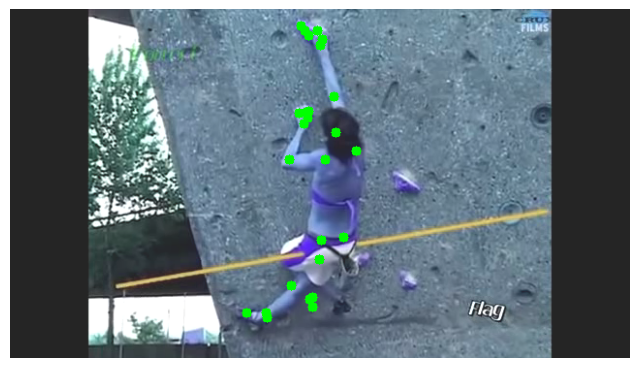

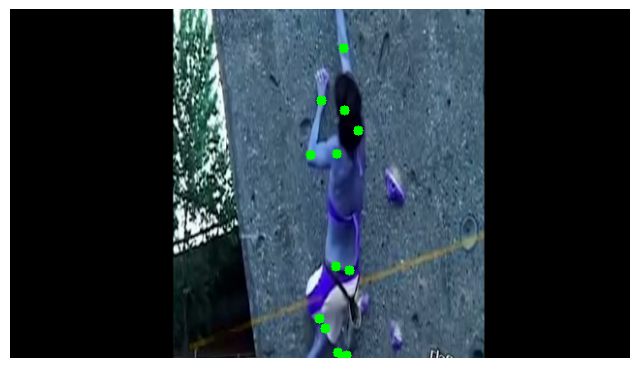

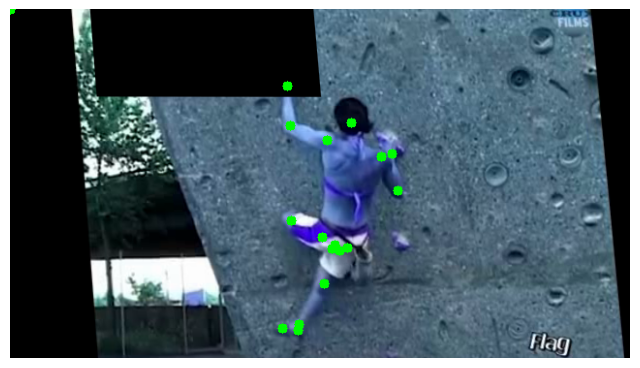

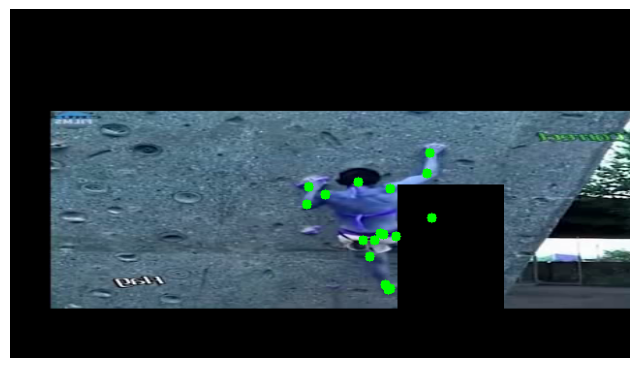

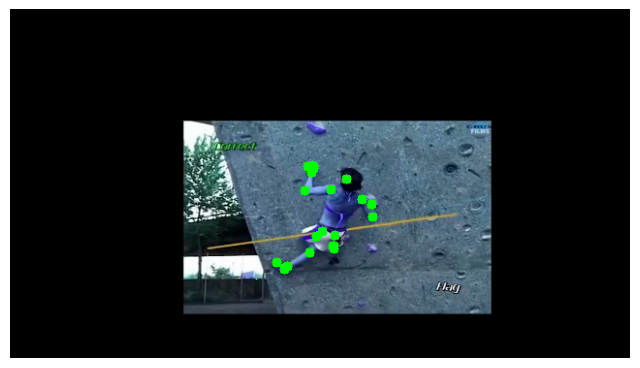

In [2]:
from cv2 import imread

from src.hpe_dnn.model import read_data
from src.hpe_dnn.augmentation import __transform_pipeline, __to_augmenting_array, __to_df_row
from src.hpe_dnn.draw import draw_augmented_keypoints

df_path = "data/df/techniques/train.pkl"
train = read_data(df_path)

def print_info(input):
    img_path = input["image_path"]
    image = imread(img_path)
    height, width, _ = image.shape
    
    xyz, vis = __to_augmenting_array(input, height, width)
    
    transformed = __transform_pipeline(image=image, keypoints=xyz)

    draw_augmented_keypoints(transformed['image'], transformed['keypoints'])

    output = __to_df_row(input, transformed['keypoints'], vis, height, width)

    for header in input.index:
        print(f"{header}: {input[header]} ===> {output[header]}")    

    return output

train.head().apply(print_info, axis=1)

In [3]:
train.head()

,NOSE_x,NOSE_y,NOSE_z,NOSE_visibility,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,LEFT_ELBOW_x,LEFT_ELBOW_y,...,LEFT_THUMB_TIP_y,LEFT_THUMB_TIP_z,LEFT_INDEX_FINGER_MCP_x,LEFT_INDEX_FINGER_MCP_y,LEFT_INDEX_FINGER_MCP_z,LEFT_PINKY_MCP_x,LEFT_PINKY_MCP_y,LEFT_PINKY_MCP_z,technique,image_path
0,0.525280,0.353929,-0.145453,0.997911,0.508288,0.432350,-0.317199,0.999628,0.450264,0.432424,...,0.293792,-0.004811,0.479193,0.295279,0.000730,0.466173,0.299412,-0.002676,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
1,0.539507,0.363188,-0.178165,0.998552,0.519075,0.448699,-0.324970,0.999847,0.457417,0.450730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
2,0.513321,0.310418,0.104551,0.999911,0.476596,0.353568,-0.053248,0.999963,0.425937,0.318189,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
3,0.510968,0.358767,0.060844,0.999489,0.472698,0.394746,-0.051879,0.999896,0.429584,0.317612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
4,0.522227,0.301074,0.034360,0.999981,0.485328,0.355894,-0.112799,0.999972,0.422636,0.364522,...,0.232883,-0.000309,0.443161,0.236982,0.002613,0.429639,0.239031,-0.002077,4,./data/img/techniques/train/BACK_FLAG/(Climbin...
